# (28751) Eggl orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '28751'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0

In [4]:
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_optical_obs_array(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)

Skipped 0 observations 
	 0 of which were non-geocentric occultations or space-based observations, 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 521 observations. Debiased 900 observations. No biasing information for 6 observations.
Applied default weight of 1 arcsec to 67 CCD observations
Deweighted 331 observations as part of deweighting scheme.


In [5]:
n_iter_max = 10
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.419			 0.522			 777.233			 0.273
2			 0.419			 0.522			 776.526			 0.273
Converged without rejecting outliers. Starting outlier rejection now.
3			 0.414			 0.505			 726.969			 0.256
4			 0.414			 0.505			 726.461			 0.256
Converged after rejecting outliers.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 4 (of 4):
RMS unweighted: 0.41387244816578495
RMS weighted: 0.5050522477776099
chi-squared: 726.461497461896
reduced chi-squared: 0.25561629045105416
square root of reduced chi-squared: 0.50558509714098
t: MJD 57708.0 TDB
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			1.13399940080e-01		3.84682048762e-08 		1.13399936337e-01		3.68846242511e-08 		-3.74316302953e-09		-0.097
q			2.23470873804e+00		9.68558823069e-08 		2.23470874756e+00		9.28075052301e-08 		+9.51977163766e-09		+0.098
tp			5.79392687933e+04		5.34637507951e-05 		5.79392687910e+04		5.11973636502e-05 		-2.32742604567e-06		-0.044
om			2.76278383443e+02		1.37615814730e-04 		2.76278384608e+02		1.37675277453e-04 		+1.16569839292e-06		+0.008
w			4.93416296052e+01		1.38193570819e-04 		4.93416280727e+01		1.38408748732e-04 		-1.53244277357e-06		-0.011
i			1.74614223393e+00		2.53752116001e-06 		1.74614241168e+00		2.56041323454e-0

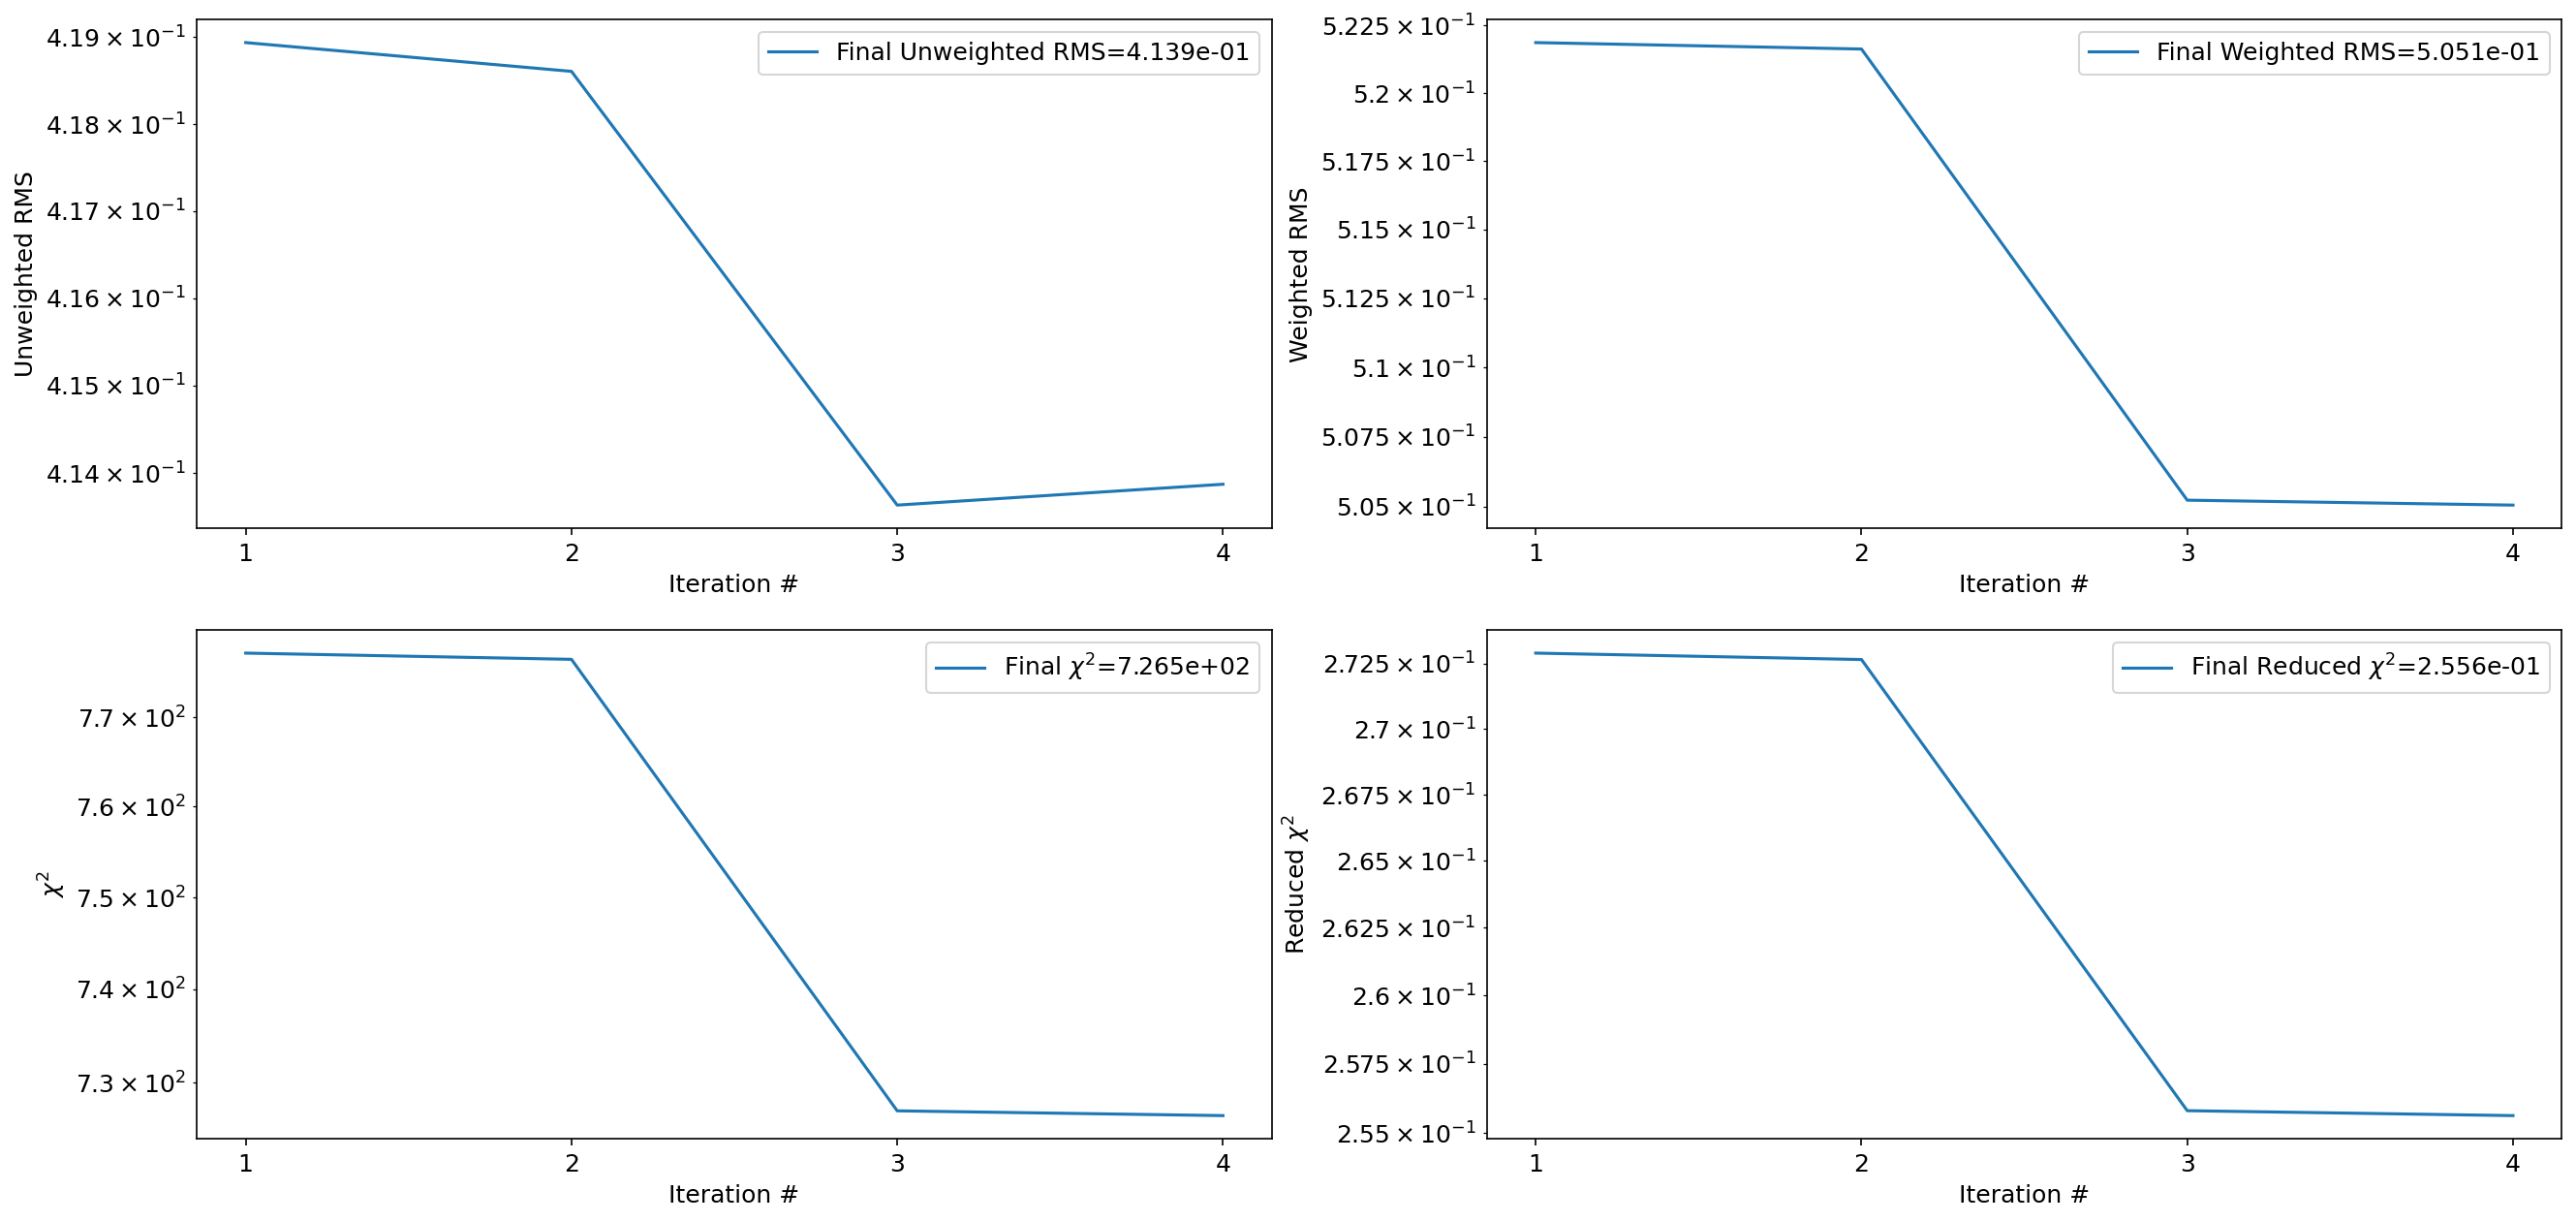

In [8]:
fit_sim.plot_summary(auto_close=True)

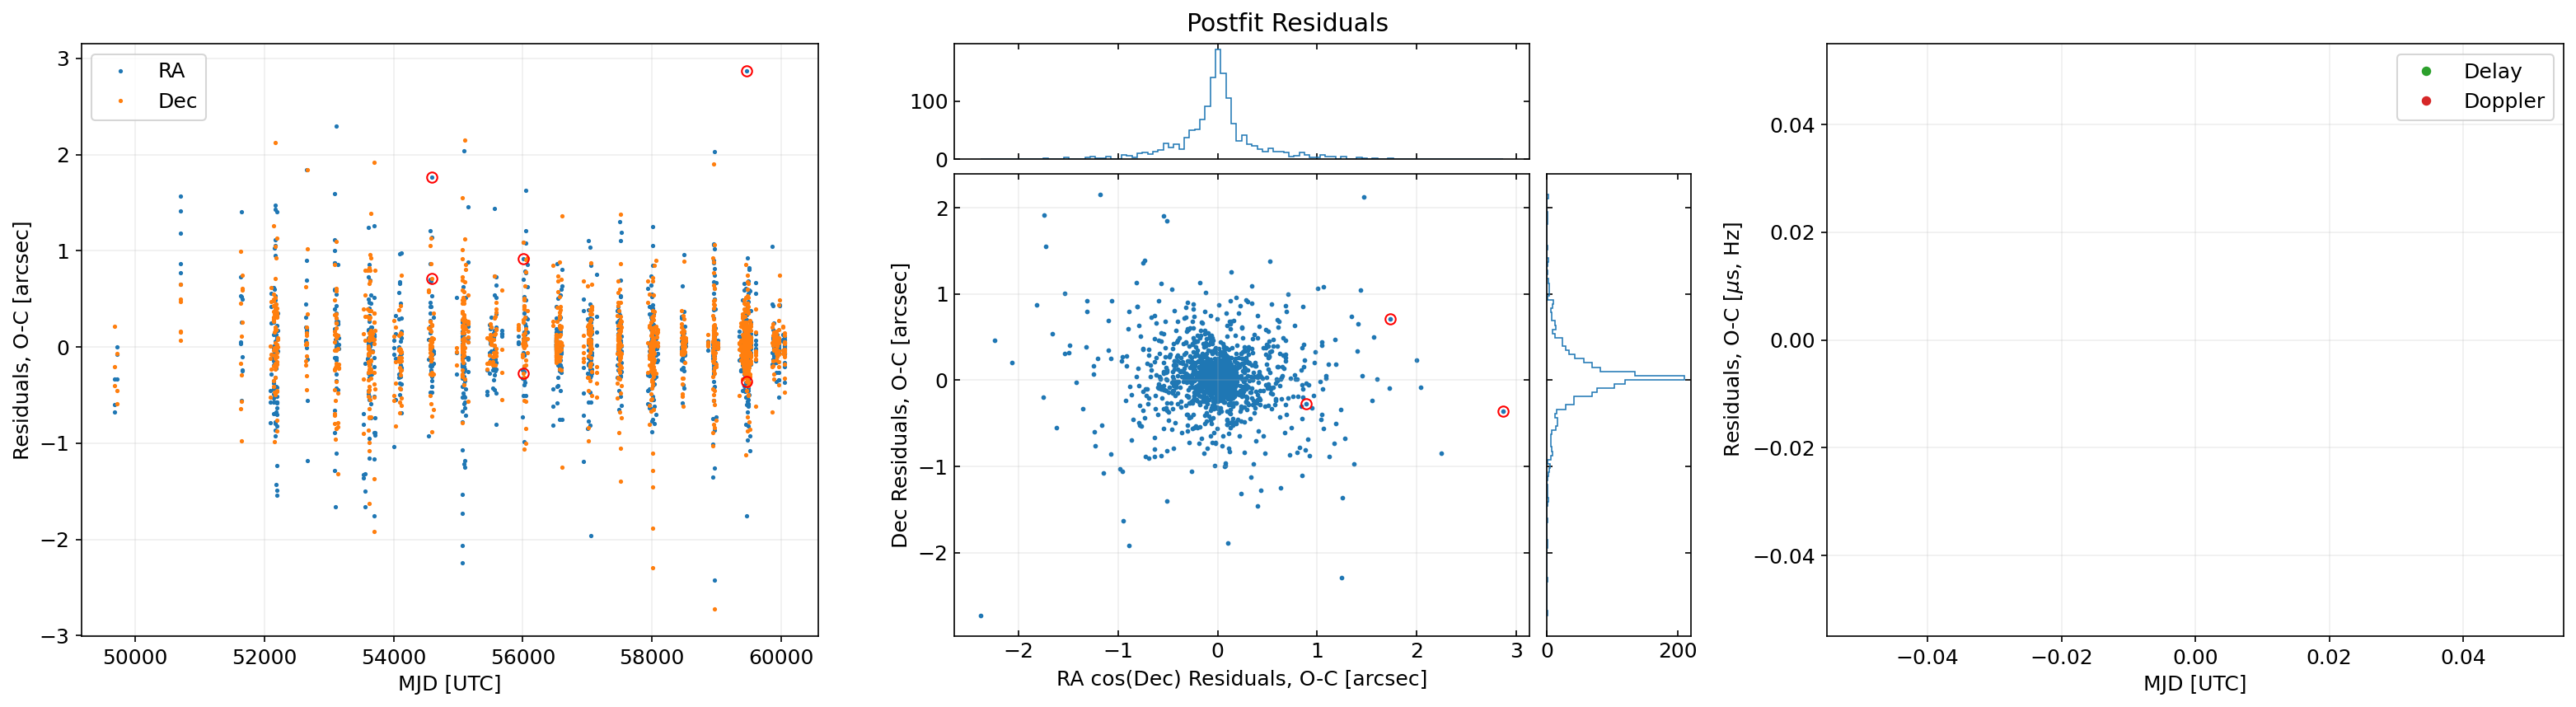

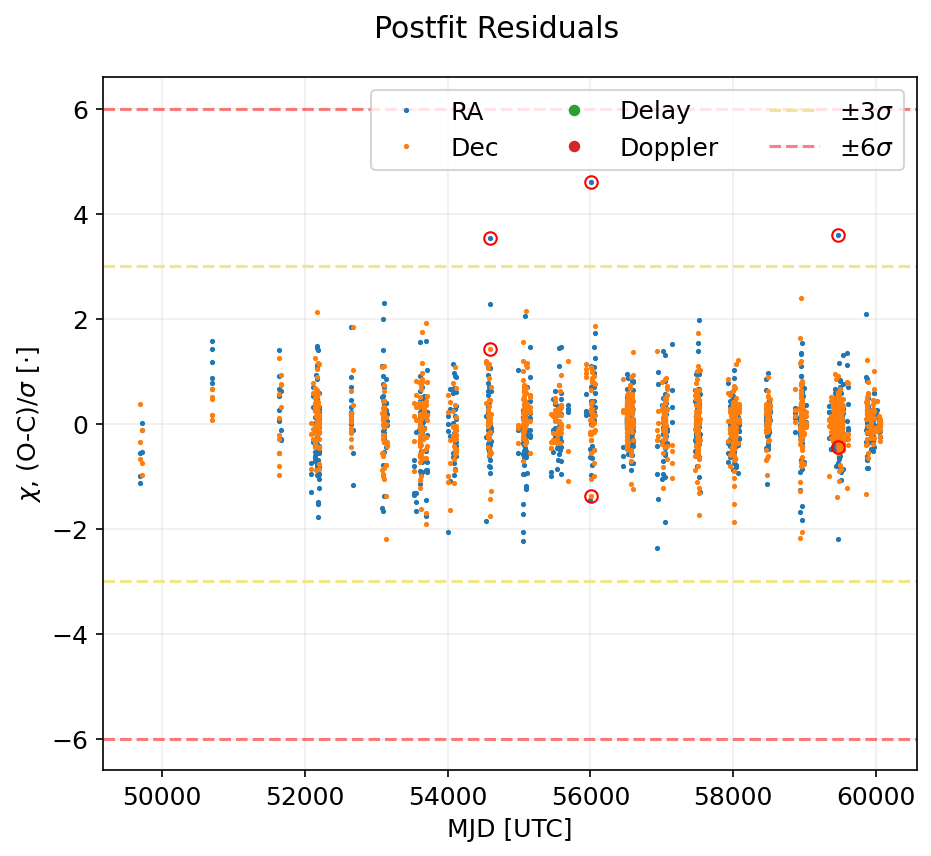

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.16
Mahalonobis distance between GRSS and JPL solution: 0.16
Bhattacharya distance between JPL and GRSS solution: 0.0015
Bhattacharya coefficient between JPL and GRSS solution: 0.9985


In [11]:
assert maha_dist_f < 3.0
assert maha_dist_0 < 3.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90